In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn import preprocessing
import sklearn.metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

In [2]:
ruta = '/content/drive/MyDrive/TFM/TFM/LiqDB/Data/LiqDBDataSet.txt'
dataset = pd.read_csv(ruta, sep="\t")

# Buscamos outliers con el algoritmo DBscan

In [3]:
# Normalizamos las características dentro del rango [0,1]
min_max_scaler = preprocessing.MinMaxScaler()

columnas = dataset.columns.tolist()
columnas.remove(columnas[0])

features_norm = min_max_scaler.fit_transform(dataset[columnas])

# Calculamos la matriz de distancias euclidianas entre todas las muestras
dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist = dist.pairwise(features_norm)

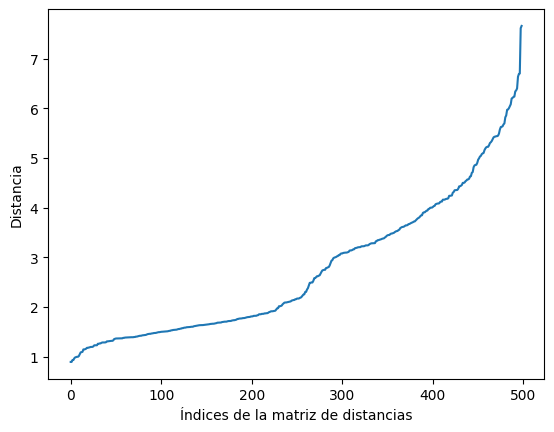

In [4]:
## DBSCAN
# Creamos matriz de vecinos más cercanos
minPts = 1
A = kneighbors_graph(features_norm, minPts, include_self=False)
Ar = A.toarray()

# Se itera sobre la lista de vecinos más cercanos y buscamos su distancia
seq = []
for i,s in enumerate(features_norm):
    for j in range(len(features_norm)):
        if Ar[i][j] != 0:
            seq.append(matdist[i][j])

# Ordenamos la lista de distancias
seq.sort()

# Enseñamos la lista
fig = plt.figure()
ax = fig.gca()

plt.plot(seq)
plt.xlabel('Índices de la matriz de distancias')
plt.ylabel('Distancia')

plt.show()

In [5]:
#Definimos número mínimo de puntos para el algoritmo DBScan
minPts = 3

print("Para los distintos epsilons, se muestra el número de clústers y outliers obtenidos con el método DBSCAN:\n")
for eps in np.arange(5, 8.5, 0.5):
  db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

Para los distintos epsilons, se muestra el número de clústers y outliers obtenidos con el método DBSCAN:

  5.00, 1, 47
  5.50, 1, 25
  6.00, 1, 15
  6.50, 1, 5
  7.00, 1, 2
  7.50, 1, 2
  8.00, 1, 0


In [6]:
eps= 6.5
db = DBSCAN(eps, min_samples=minPts).fit(features_norm)
labelsDBScan = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_outliers = list(labels).count(-1)
print ("Epsilon final:",eps, "\nClusters finales:",n_clusters_,"\nOutliers finales:", n_outliers)

Epsilon final: 6.5 
Clusters finales: 1 
Outliers finales: 0


In [7]:
outlier_DBScan_indices = np.where(labelsDBScan == -1)[0].tolist()

# Buscamos outliers con el algoritmo Isolation Forest


In [8]:
# Definimos y entrenamos el modelo Isolation Forest
# Ponemos el número de estimadores a 100 (default) y el número de outliers a encontrar el 0.2% de la muestra.
model = IsolationForest(n_estimators=100, contamination=0.006, random_state=42)

model.fit(features_norm)

outliers = model.predict(features_norm)

In [9]:
outlier_IsolationForest_indices = np.where(outliers == -1)[0].tolist()

In [10]:
outliers = outlier_DBScan_indices + outlier_IsolationForest_indices
outliers = np.unique(outliers).tolist()

In [11]:
print(outlier_DBScan_indices)
print(outlier_IsolationForest_indices)
print(outliers)

[327, 425, 435, 452, 476]
[395, 421, 435]
[327, 395, 421, 425, 435, 452, 476]


In [12]:
dataset = dataset.drop(outliers).reset_index(drop=True)

In [13]:
# Guardamos el dataset final obtenido sin outliers.
ruta = '/content/drive/MyDrive/TFM/TFM/LiqDB/Data/'
dataset.to_csv(ruta + 'LiqDBDataSetSinOutliers.csv', sep='\t', index=False)